# CE40248 Multiscale Modelling Coursework
## Molecular Dynamics

The aim of this project is to implement a simplified Molecular Dynamics (MD) or Monte Carlo (MC) simulation to estimate properties of the propylene oxide-water system that will inform the reactor model. 

The diffusivity is the priority of this project, it will be stimulate using Molecular Dynamics

$$\phi(r) = \left( \frac{\lambda}{\lambda-6} \right) \left( \frac{\lambda}{6} \right)^{6/(\lambda-6)} \varepsilon \left[ \left( \frac{\sigma}{r} \right)^\lambda - \left( \frac{\sigma}{r} \right)^6 \right]

In [79]:
import numpy as np
import matplotlib.pyplot as plt

def wrap_positions(pos, L):
    return pos - L * np.floor(pos / L)

def minimum_image(vec, L):
    return vec - L * np.round(vec / L)

In [80]:
def A_lambda(lambda_):
    """Normalization prefactor A(lambda) = lambda/(lambda-6) * (lambda/6)^(6/(lambda-6))."""
    lam = float(lambda_)
    return (lam / (lam - 6.0)) * ( (lam / 6.0) ** (6.0 / (lam - 6.0)) )

def U_LJ(r, epsilon, sigma, lambda_, rc=None, shift=True):
    """
    Mie potential U(r).
    - r: scalar or numpy array (distance)
    - epsilon: well depth (J)
    - sigma: length (m)
    - lambda_: repulsive exponent (float, >6)
    - rc: optional cutoff (same units as r). If provided and shift=True, potential is shifted so U(rc)=0.
    - returns U(r) in same units as epsilon.
    """
    r = np.asarray(r, dtype=float)
    small = 1e-20
    r = np.maximum(r, small)
    lam = float(lambda_)
    A = A_lambda(lam)
    invr = sigma / r
    invr_lambda = invr**lam
    invr6 = invr**6
    U = A * epsilon * (invr_lambda - invr6)

    if (rc is not None) and shift:
        rc_val = float(rc)
        invrc = sigma / rc_val
        Urc = A * epsilon * (invrc**lam - invrc**6)
        U = U - Urc   # shift to zero at rc
    return U

def F_LJ_over_r(r, epsilon, sigma, lambda_, rc=None, force_shift=True):
    """
    Return F(r)/r such that F_vec = (F_over_r) * rij (rij = r_vec).
    - If rc provided and force_shift True, subtract the derivative at rc to make force continuous.
    """
    r = np.asarray(r, dtype=float)
    small = 1e-20
    r = np.maximum(r, small)
    lam = float(lambda_)
    A = A_lambda(lam)

    # compute terms
    term_rep = lam * (sigma**lam) * r**(-(lam + 2.0))   # lam * sigma^lam / r^(lam+2)
    term_att = 6.0 * (sigma**6) * r**(-8.0)            # 6 * sigma^6 / r^8
    f_over_r = A * epsilon * (term_rep - term_att)

    if (rc is not None) and force_shift:
        # subtract value at rc so F(r) -> 0 at r = rc (i.e. shift the F_over_r by constant)
        rc_val = float(rc)
        term_rep_rc = lam * (sigma**lam) * rc_val**(-(lam + 2.0))
        term_att_rc = 6.0 * (sigma**6) * rc_val**(-8.0)
        f_over_r_rc = A * epsilon * (term_rep_rc - term_att_rc)
        f_over_r = f_over_r - f_over_r_rc

    return f_over_r


## SAFT parameters for Mie potential 

Coarse-Graining method: grouping several atoms into one bead to simplify the model and reduce computational load. using SAFT work. Giving epsilong and sigma from the critical properties of propylene oxide and water


In [81]:
NA = 6.02214076e23     # 1/mol
kB = 1.380649e-23      # J/K  (per molecule)
kB = kB * NA * 1e-3  # kJ/(mol*K)


#  Water from literature 
lambda_H2O = 8.395
sigma_H2O =  0.2915            # nm  
eps_over_kB_H2O = 378.87       # K    
epsilon_H2O = eps_over_kB_H2O * kB
m_H2O = 18.015       # g/mol (molecular mass)

rho_real_H2O = 1000            # kg/m^3 (1 g/cm^3)

# Propylene Oxide from SAFT 
lambda_PO_ = 11.876791
sigma_PO =  0.3084250          # nm 
eps_over_kB_PO = 228.679203     # K
epsilon_PO = eps_over_kB_PO * kB
m_PO = 58.0791     # g/mol (molecular mass)

rho_real_PO = 830            # kg/m^3 

## Composition and Number of Molecules 

In [82]:
x_H2O = 0.95         # mole fraction Water (beads)
x_PO = 1.0 - x_H2O   # mole fraction Propylene Oxide(beads)
m_mix = (x_H2O * m_H2O + x_PO * m_PO)  # weighted average mass (kg)

Ngrid = 6         # number of particles per axis
N = Ngrid**3

N_water = int(round(N * x_H2O))
N_PO = N - N_water
print(f"Composition -> N_water={N_water}, N_PO={N_PO}, total={N_water+N_PO}")

Composition -> N_water=205, N_PO=11, total=216


## PBC box length and volume

In [83]:
# Volume per particle in nm^3
rho_H2O_g_cm3 = rho_real_H2O / 1000.0  # 1.0
rho_PO_g_cm3  = rho_real_PO  / 1000.0  # 0.83

# Molecular Volume in nm^3
# factor 10^21 converts cm^3 to nm^3
V_H2O = (m_H2O / NA) / rho_H2O_g_cm3 * 1e21
V_PO  = (m_PO  / NA) / rho_PO_g_cm3  * 1e21

V_mix = x_H2O * V_H2O + x_PO * V_PO
print(f"Volume per particle: {V_mix:.4f} nm^3")

# Box size
box_volume_nm3 = N * V_mix
L = box_volume_nm3**(1/3) # No extra conversion needed, already in nm

Volume per particle: 0.0342 nm^3


In [84]:
# Initial positions: slightly perturbed cubic lattice
a = L / Ngrid
coords = np.linspace(0.5*a, L-0.5*a, Ngrid)
x, y, z = np.meshgrid(coords, coords, coords, indexing='ij')
positions = np.vstack([x.ravel(), y.ravel(), z.ravel()]).T
positions += 0.05*a * (np.random.rand(N,3) - 0.5)
positions = wrap_positions(positions, L)


## Lorentz-Berthelot mixing rules 

- We need matrices for σ, ε, and λ so that we can apply the correct interaction parameters for every possible pair of particle types in our mixture, as required by the mixing rules. This ensures physically accurate simulation of mixed systems.

- 4 values in the matrix to cover all possible pairs (including cross interactions), even though for two species, some values are duplicates due to symmetry. This ensures the correct parameters are always used for every pair in the simulation.

In [85]:
# 1. Assign types: 0 for water, 1 for PO
types = np.zeros(N, dtype=int)
types[N_water:] = 1  # first N_water are water, rest are PO

# 2. Pure component parameters
sigma = [sigma_H2O, sigma_PO]
epsilon = [epsilon_H2O, epsilon_PO]
lambda_ = [lambda_H2O, lambda_PO_]

# 3. Lorentz-Berthelot mixing rules
sigma_matrix = np.zeros((2,2))
epsilon_matrix = np.zeros((2,2))
lambda_matrix = np.zeros((2,2))
for i in range(2):
    for j in range(2):
        sigma_matrix[i,j] = 0.5 * (sigma[i] + sigma[j])
        epsilon_matrix[i,j] = np.sqrt(epsilon[i] * epsilon[j])
        lambda_matrix[i,j] = 0.5 * (lambda_[i] + lambda_[j])        

- epsilon_matrix[0,0] is for water–water,
- epsilon_matrix[1,1] is for PO–PO,
- epsilon_matrix[0,1] (and [1,0]) is for water–PO pairs.

In [ ]:
# After defining "types" array:
# 1. Assign types: 0 for water, 1 for PO
types = np.zeros(N, dtype=int)
types[N_water:] = 1 

# Create a mass array of shape (N, 1) for easy broadcasting
masses = np.zeros((N, 1))
masses[types == 0] = m_H2O
masses[types == 1] = m_PO
# --- NEW CODE END ---

## MD parameters, box length and cut off radius

In [ ]:
# MD parameters
dt = 0.001
rc = 2.5 * sigma_matrix[0,1]  # in nm
rskin = 0.3 * sigma_matrix[0,1]
rlist = rc + rskin 

print(f"Box length= {L:.4f} nm")
print(f"Cutoff radius 2rc = {2*rc:.4f} nm")

Box length= 1.9481 nm
Cutoff radius 2rc = 1.4998 nm


## Neighbour and Force 

In [88]:
# %%
def build_neighbor_list(positions, L, rc_list):
    N = positions.shape[0]
    nlist = [[] for _ in range(N)]
    for i in range(N-1):
        rij = positions[i+1:] - positions[i]
        rij = minimum_image(rij, L)
        dist2 = np.sum(rij*rij, axis=1)
        mask = dist2 < rc_list**2
        js = np.nonzero(mask)[0] + (i+1)
        for j in js:
            nlist[i].append(j)
    return nlist

def compute_forces_verlet(positions, L, rc, nlist):
    N = positions.shape[0]
    forces = np.zeros_like(positions)
    pot = 0.0
    virial = 0.0  # <--- NEW: Virial accumulator for Pressure
    
    for i in range(N-1):
        for j in nlist[i]:
            type_i = types[i]
            type_j = types[j]
            sigma_ij = sigma_matrix[type_i, type_j]
            epsilon_ij = epsilon_matrix[type_i, type_j]
            lambda_ij = lambda_matrix[type_i, type_j]
            
            rij = positions[i] - positions[j]
            rij = minimum_image(rij, L)
            r = np.linalg.norm(rij)
            
            if r < rc:
                fij = F_LJ_over_r(r, epsilon_ij, sigma_ij, lambda_ij) * rij
                forces[i] += fij
                forces[j] -= fij
                pot += U_LJ(r, epsilon_ij, sigma_ij, lambda_ij)
                
                # Virial Calculation (Required for correct NPT pressure)
                # W = Sum( F_ij * r_ij )
                virial += np.dot(fij, rij)
            
    return forces, pot, virial

def max_displacement(p, p_ref, L):
    disp = minimum_image(p - p_ref, L)
    return np.max(np.linalg.norm(disp, axis=1))

# Initialize (Note: unpacking 3 values now)
neighbor_list = build_neighbor_list(positions, L, rlist)
forces, pot, virial = compute_forces_verlet(positions, L, rc, neighbor_list)
ref_positions = positions.copy()

## Thermostat for NVT (Berendsen)

$$ \lambda = \sqrt{1 + \frac{\Delta t}{\tau} \left( \frac{T_{\text{target}}}{T(t)} - 1 \right)} $$

where:
- $\Delta t$ is the timestep
- $\tau$ is the thermostat relaxation time (coupling constant)
- $T_{\text{target}}$ is the target temperature
- $T(t)$ is the instantaneous temperature at time $t$
- $\lambda$ is the velocity scaling factor applied at each step

This Berendsen thermostat equation rescales particle velocities to gently drive the system temperature toward the target value. The strength of the coupling is controlled by $\tau$: smaller $\tau$ means stronger (faster) temperature control, while larger $\tau$ means weaker (slower) control.


In [89]:

def get_temperature(velocities, masses):
    N = velocities.shape[0]
    # KE = 0.5 * m * v^2
    # result is in kJ/mol because m is g/mol and v is nm/ps
    kin_per_particle = 0.5 * masses * velocities**2
    total_kin = np.sum(kin_per_particle)
    
    dof = 3.0 * N - 3.0
    # T = 2 * KE / (dof * kB)
    return (2.0 * total_kin) / (dof * kB)


def apply_berendsen_thermostat(velocities, masses, T_target, dt, tau):
    T_current = get_temperature(velocities, masses) # Pass masses here
    if T_current == 0.0: return velocities 
    lambda_sq = 1.0 + (dt / tau) * (T_target / T_current - 1.0)
    if lambda_sq < 0.0: return velocities
    return velocities * np.sqrt(lambda_sq)

In [ ]:
# --- Initial Velocities Setup ---
T_target = 298.15  # Kelvin # Adjust this temperature to assess predictive capacity 
# v_std = sqrt(kB * T / m)
vel_std_water = np.sqrt(kB * T_target / m_H2O)
vel_std_PO    = np.sqrt(kB * T_target / m_PO)

velocities = np.zeros((N, 3))
velocities[types == 0] = np.random.normal(0, vel_std_water, size=(N_water, 3))
velocities[types == 1] = np.random.normal(0, vel_std_PO, size=(N_PO, 3))
velocities -= velocities.mean(axis=0)


## Barostat NPT for calculation of mixture density

The NPT (constant pressure, temperature) barostat is only used here **to equilibrate the system and measure the equilibrium density of the mixture**. This step allows the simulation box volume to fluctuate so the system can reach the correct density at the target pressure and temperature.

- After running the NPT barostat, the average box size and density are recorded.
- The system is then switched to an NVT (constant volume, temperature) ensemble using the equilibrated box size for all further analysis.

$$
\mu = \left[1 + \frac{\Delta t}{\tau_p} \kappa_T (P_{\text{inst}} - P_{\text{target}})\right]^{1/3}
$$

where:
- $\Delta t$ is the timestep
- $\tau_p$ is the barostat relaxation time
- $\kappa_T$ is the isothermal compressibility
- $P_{\text{inst}}$ is the instantaneous pressure
- $P_{\text{target}}$ is the target pressure

In [ ]:

def run_npt_density_equilibration(
    positions, velocities, types, sigma_matrix, epsilon_matrix, lambda_matrix,
    masses, L_init, dt=0.002, steps=10000, 
    T_target=298.15, P_target_bar=1.0, tau_t=0.1, tau_p=2.0, compressibility=4.5e-5
):
    print(f"Starting NPT Equilibration...")
    N = positions.shape[0]
    L = L_init
    inv_masses = 1.0 / masses
    
    # Pressure Unit Conversion: 1 kJ/(mol nm^3) = 16.6054 bar
    P_conv_factor = 16.6054
    
    neighbor_list = build_neighbor_list(positions, L, rlist)
    ref_positions = positions.copy()
    
    # Compute Initial Forces & Virial
    forces, pot, virial = compute_forces_verlet(positions, L, rc, neighbor_list)
    
    V_trace = []
    
    for step in range(steps):
        # 1. Velocity Verlet (First Half)
        acc = forces * inv_masses
        velocities += 0.5 * acc * dt
        positions += velocities * dt
        positions = wrap_positions(positions, L)
        
        # --- BAROSTAT START ---
        V = L**3
        
        # Calculate Kinetic Energy
        kin_total = 0.5 * np.sum(masses * velocities**2)
        
        # Calculate Pressure (Kinetic + Virial)
        # P = (2*K + W) / 3V
        P_internal = (2.0 * kin_total + virial) / (3.0 * V)
        
        # Convert to bar
        P_inst_bar = P_internal * P_conv_factor
        
        # Scale Box
        # mu = 1 - (dt/tau_p) * beta * (P_target - P_inst)
        scaling_factor = 1.0 - (dt / tau_p) * compressibility * (P_target_bar - P_inst_bar)
        
        # Safety Clip
        scaling_factor = np.clip(scaling_factor, 0.99, 1.01)
        
        # Apply Scaling
        L *= scaling_factor**(1/3)
        positions *= scaling_factor**(1/3) 
        # --- BAROSTAT END ---

        # 2. Neighbor List
        if max_displacement(positions, ref_positions, L) > 0.5*rskin:
            neighbor_list = build_neighbor_list(positions, L, rlist)
            ref_positions = positions.copy()
            
        # 3. Forces & Virial
        forces, pot, virial = compute_forces_verlet(positions, L, rc, neighbor_list)
        
        # 4. Velocity Verlet (Second Half)
        acc = forces * inv_masses
        velocities += 0.5 * acc * dt
        
        # 5. Thermostat
        velocities = apply_berendsen_thermostat(velocities, masses, T_target, dt, tau_t)
        
        V_trace.append(L**3)

    # Calculate final density
    V_eq_nm3 = np.mean(V_trace[-int(steps*0.2):])
    total_mass_kg = (np.sum(masses) / NA) * 1e-3
    V_eq_m3 = V_eq_nm3 * 1e-27
    density = total_mass_kg / V_eq_m3
    
    print(f"NPT Finished. Final Density: {density:.2f} kg/m^3")
    return V_eq_nm3**(1/3), density

## New box length and density after NPT

In [92]:
print("--- Starting NPT Equilibration ---")

# Run the function
L_equilibrated, rho_equilibrated = run_npt_density_equilibration(
    positions, velocities, types, sigma_matrix, epsilon_matrix, lambda_matrix,
    masses, L, dt=0.002, steps=10000, 
    T_target=298.15, P_target_bar=1.0, tau_t=0.1, tau_p=2.0, compressibility=4.5e-5
)

# CRITICAL: Update the global box length L to the new equilibrated size
L = L_equilibrated 

print("-" * 30)
print(f"Equilibration Complete.")
print(f"New Box Length: {L:.4f} nm")
print(f"Equilibrated Density: {rho_equilibrated:.2f} kg/m^3")
print("-" * 30)

--- Starting NPT Equilibration ---
Starting NPT Equilibration...
NPT Finished. Final Density: 1020.55 kg/m^3
------------------------------
Equilibration Complete.
New Box Length: 1.9173 nm
Equilibrated Density: 1020.55 kg/m^3
------------------------------


In [ ]:
# Get final volume from NPT
L_final = L
V_final_nm3 = L_final**3

# Calculate Total Mass of the system
# m_H2O is in g/mol. 
# Total Mass (g) = (Sum of molar masses) / Avogadro Constant
total_molar_mass_g_mol = N_water * m_H2O + N_PO * m_PO
real_mass_g = total_molar_mass_g_mol / NA  # <--- CRITICAL FIX

# Convert to kg
real_mass_kg = real_mass_g * 1e-3

# Convert Volume to m^3
V_final_m3 = V_final_nm3 * 1e-27

density = real_mass_kg / V_final_m3

print(f"Final Box Length: {L_final:.3f} nm")
print(f"Total Mass: {real_mass_kg:.3e} kg")
print(f"Final Density: {density:.2f} kg/m^3")

Final Box Length: 1.917 nm
Total Mass: 7.193e-24 kg
Final Density: 1020.55 kg/m^3


## Unwrapping

In [ ]:
# %%
prev_wrapped = positions.copy()
shifts = np.zeros_like(positions)

def unwrap_positions(curr_wrapped, prev_wrapped, shifts, L):
    # 1. Calculate the shortest distance (Minimum Image Convention)
    disp = minimum_image(curr_wrapped - prev_wrapped, L)
    
    # 2. Calculate the 'raw' difference without PBC
    raw_diff = curr_wrapped - prev_wrapped
    
    # 3. Update shifts
    #    Add the difference between the MIC path and the raw path.
    #    Correction = 0.2 - (-9.8) = +10.0
    #    New coord = 0.1 + 10.0 = 10.1 (Correct!)
    
    shifts = shifts + (disp - raw_diff) 
    
    unwrapped = curr_wrapped + shifts
    return unwrapped, shifts

## On the fly 

In [ ]:
sample_stride = 10
store_max = 2000
frames = []
times = []
msd_accum = None
msd_count = None
time_accum = None

def ensure_buffers(nstored):
    global msd_accum, msd_count, time_accum
    if msd_accum is None or len(msd_accum) < nstored:
        msd_accum = np.zeros(nstored, dtype=float)
        msd_count = np.zeros(nstored, dtype=int)
        time_accum = np.arange(nstored, dtype=int)

def update_msd_with_frame(frame, tstep):
    global frames, times, msd_accum, msd_count
    frames.append(frame.copy())
    times.append(tstep)
    if len(frames) > store_max:
        frames.pop(0)
        times.pop(0)
    ensure_buffers(len(frames))
    origin = frames[0:-1]
    for k, f0 in enumerate(origin):
        lag = len(frames) - 1 - k
        if lag <= 0:
            continue
        dr = frames[-1] - f0
        msd = np.mean(np.sum(dr*dr, axis=1))
        msd_accum[lag] += msd
        msd_count[lag] += 1

def get_msd_curve(dt, stride):
    mask = msd_count > 0
    t = time_accum[mask] * (dt * stride)
    msd = msd_accum[mask] / msd_count[mask]
    return t, msd

## MD Run with MSD Sampling 

τ (tau) is the "relaxation time" and controls how strong the thermostat is.
- A small τ (e.g., 0.1) is a strong thermostat. It's like a powerful AC unit that forces the temperature to change very quickly.

- A large τ (e.g., 2.0) is a weak thermostat. It's like a small fan, gently nudging the temperature. This is usually preferred. A good rule of thumb is τ≈100 to 1000×dt.

In [ ]:
# Thermostat parameters
T_target = 298.15  # Target reduced temperature
tau_t = 0.1     # Thermostat coupling time (in reduced units)// relaxtation time 

# NVT production run
save_stride = 50 
traj_unwrap = [] 
steps = 10000 

global_step = 0
KE, PE, TE, TEMP = [], [], [], [] # <-- ADDED TEMP

# Reset MSD accumulators for the new run
msd_accum = None 
msd_count = None
time_accum = None
frames = []
times = []

T_init = get_temperature(velocities, masses)
velocities *= np.sqrt(T_target / T_init)

print(f"Starting equilibration run. Target T = {T_target}")


Starting equilibration run. Target T = 298.15


In [ ]:
# Pre-calculate mass inverse for speed
inv_masses = 1.0 / masses 

print(f"Starting equilibration. Target T = {T_target} K")

for step in range(steps):
    # 1. Velocity Update (Half Step) -> v = v + 0.5 * (F/m) * dt
    # note: forces are in kJ/(mol nm), mass in g/mol. Result is nm/ps^2. GROMAC units 
    acc = forces * inv_masses  
    velocities += 0.5 * acc * dt
    
    # 2. Position Update
    positions += velocities * dt
    positions = wrap_positions(positions, L)
    
    # Neighbor List Check
    if max_displacement(positions, ref_positions, L) > 0.5*rskin:
        neighbor_list = build_neighbor_list(positions, L, rlist)
        ref_positions = positions.copy()
        
    # 3. Force Calculation
    forces, pot, virial = compute_forces_verlet(positions, L, rc, neighbor_list)
    
    # 4. Velocity Update (Half Step)
    acc = forces * inv_masses
    velocities += 0.5 * acc * dt

    # 5. Thermostat (Berendsen)
    velocities = apply_berendsen_thermostat(velocities, masses, T_target, dt, tau_t)

    # Kinetic Energy (Explicit units)
    kin_total = np.sum(0.5 * masses * velocities**2)
    
    # Temperature
    T_current = (2.0 * kin_total) / ((3.0 * N - 3.0) * kB)
    
    TE.append(kin_total + pot)
    KE.append(kin_total)
    PE.append(pot)
    TEMP.append(T_current)
    
    # Unwrapping + MSD sampling 
    unwrapped, shifts = unwrap_positions(positions, prev_wrapped, shifts, L)
    prev_wrapped = positions.copy()
    
    if (step % sample_stride) == 0:
        update_msd_with_frame(unwrapped, step)
        
    if (step % save_stride) == 0:
        traj_unwrap.append(unwrapped.copy())

print("Finished.")

Starting equilibration. Target T = 298.15 K
Finished.


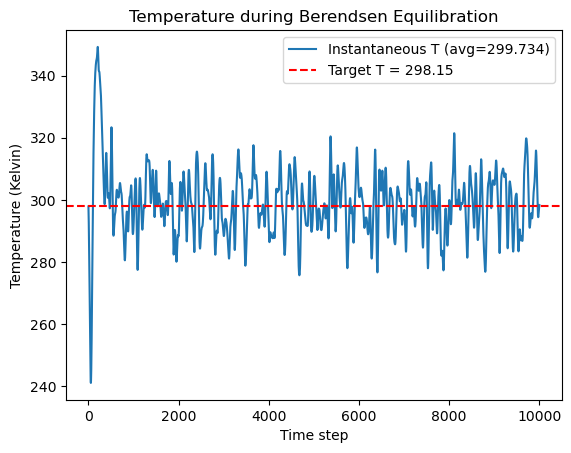

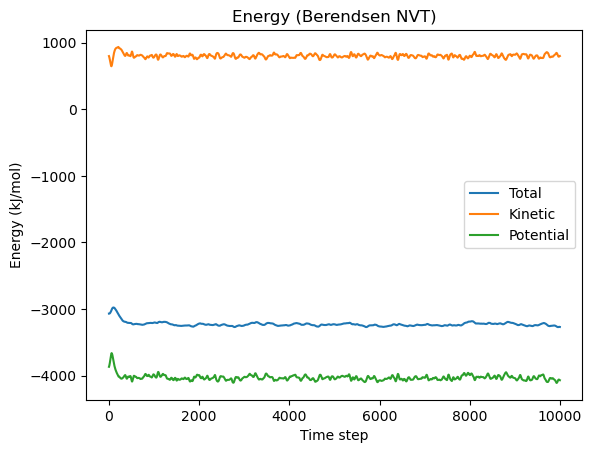

In [ ]:
plt.plot(TEMP, label=f'Instantaneous T (avg={np.mean(TEMP[-500:]):.3f})')
plt.axhline(y=T_target, color='r', linestyle='--', label=f'Target T = {T_target}')
plt.xlabel('Time step'); plt.ylabel('Temperature (Kelvin)')
plt.title('Temperature during Berendsen Equilibration')
plt.legend(); plt.show()

# Plot Energy 
plt.plot(TE, label='Total'); plt.plot(KE, label='Kinetic'); plt.plot(PE, label='Potential')
plt.xlabel('Time step'); plt.ylabel('Energy (kJ/mol)')
plt.title('Energy (Berendsen NVT)'); plt.legend(); plt.show()

## Extracting D from the Linear Regime of MSD

Estimated D* = 0.00702


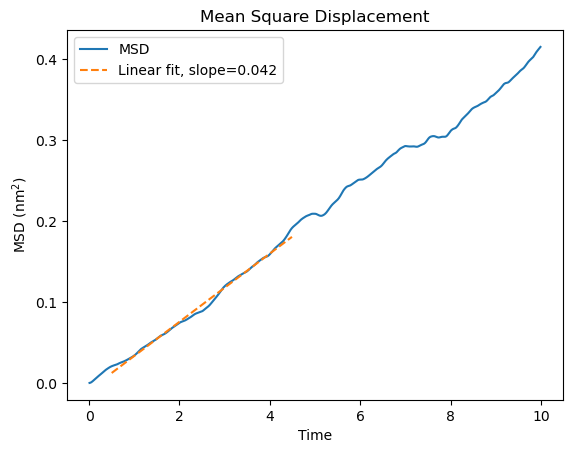

In [99]:
t, msd = get_msd_curve(dt, sample_stride)

n = len(t)
i_start = max(1, int(0.05*n))
i_end = max(i_start+5, int(0.45*n))


t_fit = t[i_start:i_end]
msd_fit = msd[i_start:i_end]


A, B = np.polyfit(t_fit, msd_fit, 1)
D_est = A / 6.0
print(f"Estimated D* = {D_est:.5f}")


plt.plot(t, msd, label='MSD')
plt.plot(t_fit, A*t_fit + B, '--', label=f'Linear fit, slope={A:.3f}')
plt.xlabel('Time')
plt.ylabel('MSD (nm$^2$)')
plt.title('Mean Square Displacement')
plt.legend()
plt.show()


## Calculate Diffusivity of the PO in the mixture

In [114]:
# %%
# ## Diffusivity in real units
# The simulation ran in real units: Length = nm, Time = ps.
# Therefore, the slope D_est is ALREADY in units of [nm^2 / ps].

# Convert nm^2/ps to m^2/s
# 1 nm^2 = 10^-18 m^2
# 1 ps   = 10^-12 s
# Factor = 10^-18 / 10^-12 = 10^-6


print(f"Slope (D_est) directly from MSD: {D_est:.5f} nm^2/ps")

D_phys_m2_s = D_est * 1e-6

print(f"Physical diffusion coefficient:")
print(f"D = {D_phys_m2_s:.4e} m^2/s")

Slope (D_est) directly from MSD: 0.00702 nm^2/ps
Physical diffusion coefficient:
D = 7.0196e-09 m^2/s


## Radial Distribution

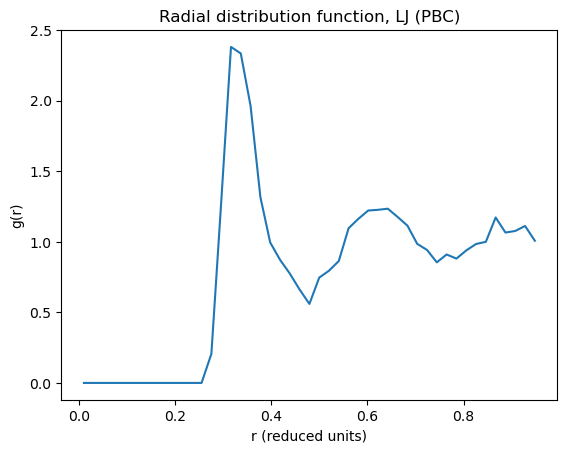

In [ ]:
def radial_distribution(traj_unwrap, L, dr=0.02, rmax=None):
    pos = traj_unwrap[-1]
    N = pos.shape[0]
    if rmax is None:
        rmax = 0.5*L
    nbins = int(np.floor(rmax/dr))
    # pair distances with MIC
    dists = []
    for i in range(N-1):
        rij = pos[i+1:] - pos[i]
        rij = minimum_image(rij, L)
        r = np.linalg.norm(rij, axis=1)
        dists.append(r)
    dists = np.concatenate(dists, axis=0)
# keep only distances in (0, rmax)
    dists = dists[(dists > 0.0) & (dists < rmax)]
    
    # histogram
    hist, edges = np.histogram(dists, bins=nbins, range=(0.0, rmax))
    r_centers = 0.5*(edges[1:] + edges[:-1])
    
    # normalization
    rho = N / (L**3)
    shell_vol = 4.0*np.pi * (r_centers**2) * dr
    ideal = rho * N * shell_vol
    g = (2.0 * hist) / ideal # factor 2 for i-j and j-i
    return r_centers, g

r, g = radial_distribution(traj_unwrap, L, dr=0.02)
plt.plot(r, g)
plt.xlabel('r (nm)')
plt.ylabel('g(r)')
plt.title('Radial distribution function, LJ (PBC)')
plt.show()

## Calculating Heat Capacity ($C_v$) from MD Simulation

Heat capacity at constant volume ($C_v$) can be estimated from energy fluctuations in an NVT (constant volume and temperature) simulation. The key steps are:

1. **Run a long NVT simulation** and record the total energy (kinetic + potential) at each timestep after equilibration.
2. **Calculate the mean and variance of the total energy** over the production (steady-state) part of the trajectory.
3. **Compute $C_v$ using the fluctuation formula:**
   
   $$ C_v = \frac{\langle E^2 \rangle - \langle E \rangle^2}{k_B T^2} $$
   where $E$ is the total energy, $k_B$ is Boltzmann's constant, and $T$ is the temperature.

4. **Convert to per-particle or per-mole units** as needed.


In [ ]:
# --- Heat Capacity Calculation from Energy Fluctuations ---
# Use only the production part of the trajectory (e.g., last 50% of steps)
import numpy as np

# Example: use last 50% of data for production
nprod = len(TE) // 2
E_prod = np.array(TE)[-nprod:]
T_prod = np.array(TEMP)[-nprod:]
T_mean = np.mean(T_prod)

# Boltzmann constant (kJ/(mol*K))
kB_kJ = 1.380649e-23 * 6.02214076e23 * 1e-3

# Fluctuation formula (per system)
C_v = (np.mean(E_prod**2) - np.mean(E_prod)**2) / (kB_kJ * T_mean**2)
print(f"Heat capacity (system): C_v = {C_v:.4f} kJ/(mol·K)")

# Per particle (dimensionless, in units of kB)
C_v_per_particle = C_v*1000 / N
print(f"Heat capacity per particle: C_v/N = {C_v_per_particle:.4f} (J/(mol·K)")

Heat capacity (system): C_v = 0.4552 kJ/(mol·K)
Heat capacity per particle: C_v/N = 2.1076 (J/(mol·K)


## Monte Carlo Simulation 

Monte Carlo (MC) methods can be used to estimate equilibrium properties such as the density or energy of a liquid mixture. A simple Metropolis MC simulation for a binary mixture using the same Mie/LJ potential as the MD was set up below.

Starting MC. Initial Energy: -4068.11 kJ/mol
MC Finished.
Acceptance Rate: 31.66% (Aim for 30-50%)
Mean Energy: -4031.393 kJ/mol


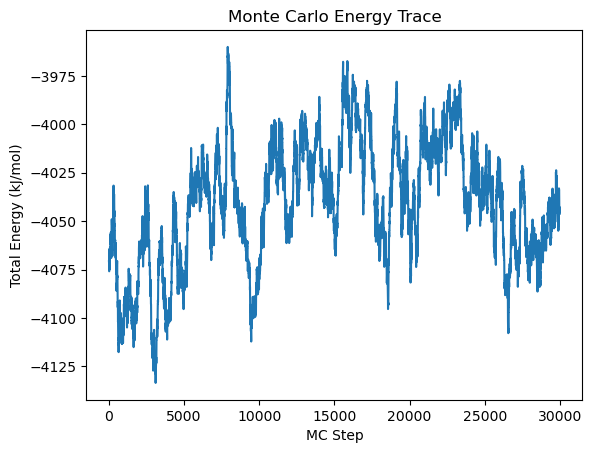

In [104]:

import numpy as np

# Setup parameters
Nsteps = 30000
mc_positions = positions.copy()
energy_trace = []
acc_count = 0

# Maximum displacement (tune this to get ~30-50% acceptance)
max_disp = 0.1  # nm

# --- Helper: Calculate energy of ONE particle 'idx' against all others ---
def get_particle_energy(idx, pos_i, all_positions, L):
    E_i = 0.0
    # Loop over all other particles
    # (Note: In pure Python this is slow, but faster than recalculating the whole box)
    for j in range(N):
        if idx == j: continue
        
        type_i = types[idx]
        type_j = types[j]
        s = sigma_matrix[type_i, type_j]
        e = epsilon_matrix[type_i, type_j]
        lam = lambda_matrix[type_i, type_j]
        
        rij = pos_i - all_positions[j]
        rij = minimum_image(rij, L)
        r = np.linalg.norm(rij)
        
        if r < rc:
            E_i += U_LJ(r, e, s, lam)
    return E_i

# --- Helper: Calculate Total System Energy (Only called once) ---
def get_total_system_energy(positions, L):
    E_total = 0.0
    for i in range(N-1):
        for j in range(i+1, N):
            type_i = types[i]
            type_j = types[j]
            s = sigma_matrix[type_i, type_j]
            e = epsilon_matrix[type_i, type_j]
            lam = lambda_matrix[type_i, type_j]
            rij = positions[i] - positions[j]
            rij = minimum_image(rij, L)
            r = np.linalg.norm(rij)
            if r < rc:
                E_total += U_LJ(r, e, s, lam)
    return E_total

# --- MC MAIN LOOP ---
current_total_E = get_total_system_energy(mc_positions, L)

print(f"Starting MC. Initial Energy: {current_total_E:.2f} kJ/mol")

for step in range(Nsteps):
    # 1. Pick random particle
    i = np.random.randint(N)
    
    # 2. Calculate energy of OLD state for this particle only
    E_i_old = get_particle_energy(i, mc_positions[i], mc_positions, L)
    
    # 3. Propose Move
    disp = (np.random.rand(3) - 0.5) * max_disp
    pos_i_new = mc_positions[i] + disp
    pos_i_new = wrap_positions(pos_i_new, L)
    
    # 4. Calculate energy of NEW state for this particle only
    E_i_new = get_particle_energy(i, pos_i_new, mc_positions, L)
    
    # 5. Delta Energy
    # Note: E_i includes interactions with all j. 
    # The change in total system energy is exactly (E_new - E_old).
    dE = E_i_new - E_i_old
    
    # 6. Metropolis Criterion
    accepted = False
    if dE < 0:
        accepted = True
    else:
        # kB must be in kJ/mol/K (0.008314)
        if np.random.rand() < np.exp(-dE / (kB * T_target)):
            accepted = True
            
    # 7. Update State
    if accepted:
        mc_positions[i] = pos_i_new
        current_total_E += dE
        acc_count += 1
    
    # 8. Sampling (MUST happen every step, accepted or not)
    energy_trace.append(current_total_E)

# --- Analysis ---
acceptance_rate = acc_count / Nsteps * 100
mean_E = np.mean(energy_trace[int(Nsteps/2):]) # Average second half

print(f"MC Finished.")
print(f"Acceptance Rate: {acceptance_rate:.2f}% (Aim for 30-50%)")
print(f"Mean Energy: {mean_E:.3f} kJ/mol")

plt.plot(energy_trace)
plt.xlabel('MC Step')
plt.ylabel('Total Energy (kJ/mol)')
plt.title('Monte Carlo Energy Trace')
plt.show()

## Heat Capacity (MC)

In [113]:
# 1. Select Production Data (e.g., last 50% of steps)
# We discard the start to ensure the system is equilibrated
n_prod = int(Nsteps * 0.5)
E_prod = np.array(energy_trace[n_prod:])

# 2. Calculate Variance of Energy
# Variance = <E^2> - <E>^2
# Units: (kJ/mol)^2
var_E = np.var(E_prod)

# 3. Define Boltzmann Constant in matching units
# kB needs to be in kJ/(mol*K)
kB_kJ = 1.380649e-23 * 6.02214076e23 * 1e-3

# 4. Calculate Cv (System)
# Cv = Variance / (kB * T^2)
# Units: (kJ/mol)^2 / (kJ/mol/K * K^2) = kJ/(mol*K)
Cv_system_kJ = var_E / (kB_kJ * T_target**2)

# 5. Convert to J/(mol*K) and per-particle
Cv_system_J = Cv_system_kJ * 1000.0  # System total in J/K (per mole of systems)


Cv_per_particle_PE = Cv_system_J / N

Cv_per_partice_KE = 1.5 * kB * 1000.0  # J/(mol*K)  Cv = 3/2 R 
Cv_per_particle_J = Cv_per_particle_PE + Cv_per_partice_KE

print("-" * 30)
print(f"MC Heat Capacity Calculation")
print(f"Temperature: {T_target} K")
print(f"Energy Variance: {var_E:.4f} (kJ/mol)^2")
print(f"Cv (Total System): {Cv_system_J:.2f} J/(mol*K) (per mole of boxes)")
print(f"Cv (Per Particle): {Cv_per_particle_J:.2f} J/(mol*K)")
print("-" * 30)

------------------------------
MC Heat Capacity Calculation
Temperature: 298.15 K
Energy Variance: 784.5645 (kJ/mol)^2
Cv (Total System): 1061.51 J/(mol*K) (per mole of boxes)
Cv (Per Particle): 17.39 J/(mol*K)
------------------------------
